# Example Usage

This is a basic example using the torchvision COCO dataset from coco.py, it assumes that you've already downloaded the COCO images and annotations JSON.  You'll notice that the scale augmentations are quite extreme.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2
import numpy as np
from copy_paste import CopyPaste
from coco import CocoDetectionCP
from visualize import display_instances
import albumentations as A
import random
from matplotlib import pyplot as plt

In [307]:
from copy_paste import copy_paste_class
from torch.utils.data import Dataset
import glob

@copy_paste_class
class FigaroDataset(Dataset):
    def __init__(self, transforms=None):
        # super(FigaroDataset, self).__init__(*args)
        self.impath = glob.glob('/home/ubuntu/workspace/U-2-Net_portrait_sketch/Figaro1k/train/src/*.jpg')
        self.maskpath = glob.glob('/home/ubuntu/workspace/U-2-Net_portrait_sketch/Figaro1k/train/mask/*.pbm')
        self.transforms = transforms
        
    def __len__(self):
        return len(self.impath)

    def load_example(self, idx):
        path = self.impath[idx]
        mask_path = self.maskpath[idx]
        
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)

        class_id = 1
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin,ymin,xmax,ymax,class_id])
            boxes.append([xmin,ymin,xmax,ymax,class_id])

        # print(masks.shape)
        # masks = [masks]
        masks = [masks.squeeze(0).astype(np.uint8),masks.squeeze(0).astype(np.uint8)]
        
        output = {
                    'image': image,
                    'masks': masks,
                    'bboxes': boxes,
                }
        
        return self.transforms(**output)

In [321]:
from copy import deepcopy
from skimage.filters import gaussian

def image_copy_paste(img, paste_img, alpha, blend=True, sigma=1):
    if alpha is not None:
        if blend:
            alpha = gaussian(alpha, sigma=sigma, preserve_range=True)

        img_dtype = img.dtype
        alpha = alpha[..., None]
        img = paste_img * alpha + img * (1 - alpha)
        img = img.astype(img_dtype)

    return img

def mask_copy_paste(mask, paste_mask, alpha):
    raise NotImplementedError

def masks_copy_paste(masks, paste_masks, alpha):
    if alpha is not None:
        #eliminate pixels that will be pasted over
        masks = [
            np.logical_and(mask, np.logical_xor(mask, alpha)).astype(np.uint8) for mask in masks
        ]
        masks.extend(paste_masks)

    return masks

def extract_bboxes(masks):
    bboxes = []
    # allow for case of no masks
    if len(masks) == 0:
        return bboxes
    
    h, w = masks[0].shape
    for mask in masks:
        yindices = np.where(np.any(mask, axis=0))[0]
        xindices = np.where(np.any(mask, axis=1))[0]
        if yindices.shape[0]:
            y1, y2 = yindices[[0, -1]]
            x1, x2 = xindices[[0, -1]]
            y2 += 1
            x2 += 1
            y1 /= w
            y2 /= w
            x1 /= h
            x2 /= h
        else:
            y1, x1, y2, x2 = 0, 0, 0, 0

        bboxes.append((y1, x1, y2, x2))

    return bboxes

def bboxes_copy_paste(bboxes, paste_bboxes, masks, paste_masks, alpha, key):
    if key == 'paste_bboxes':
        return bboxes
    elif paste_bboxes is not None:
        masks = masks_copy_paste(masks, paste_masks=[], alpha=alpha)
        adjusted_bboxes = extract_bboxes(masks)

        #only keep the bounding boxes for objects listed in bboxes
        mask_indices = [box[-1] for box in bboxes]
        adjusted_bboxes = [adjusted_bboxes[idx] for idx in mask_indices]
        #append bbox tails (classes, etc.)
        adjusted_bboxes = [bbox + tail[4:] for bbox, tail in zip(adjusted_bboxes, bboxes)]

        #adjust paste_bboxes mask indices to avoid overlap
        if len(masks) > 0:
            max_mask_index = len(masks)
        else:
            max_mask_index = 0

        paste_mask_indices = [max_mask_index + ix for ix in range(len(paste_bboxes))]
        paste_bboxes = [pbox[:-1] + (pmi,) for pbox, pmi in zip(paste_bboxes, paste_mask_indices)]
        adjusted_paste_bboxes = extract_bboxes(paste_masks)
        adjusted_paste_bboxes = [apbox + tail[4:] for apbox, tail in zip(adjusted_paste_bboxes, paste_bboxes)]

        bboxes = adjusted_bboxes + adjusted_paste_bboxes

    return bboxes

In [322]:
bgpath = glob.glob('/mnt/vitasoft/kobaco/dataset/data_processing/kobaco_data/scene/**/*')

In [323]:
self_impath = glob.glob('/home/ubuntu/workspace/U-2-Net_portrait_sketch/Figaro1k/train/src/*')
self_maskpath = glob.glob('/home/ubuntu/workspace/U-2-Net_portrait_sketch/Figaro1k/train/mask/*')
#self_humanmaskpath = asdf

In [399]:
import torch
from rvm_model.model import MattingNetwork
from torchvision.transforms import Compose, ToTensor, Resize

model = torch.hub.load("PeterL1n/RobustVideoMatting", "mobilenetv3") # or "resnet50"

In [401]:
from PIL import Image
import cv2

bgr = torch.tensor([.47, 1, .6]).view(3, 1, 1).cuda()
downsample_ratio = 0.8                              # Adjust based on your video.

device = 'cuda'
def cv2_frame_to_cuda(frame):
	"""
	convert cv2 frame to tensor.
	"""
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	loader = ToTensor()
	return loader(Image.fromarray(frame)).to(device,torch.float32,non_blocking=True).unsqueeze(0)

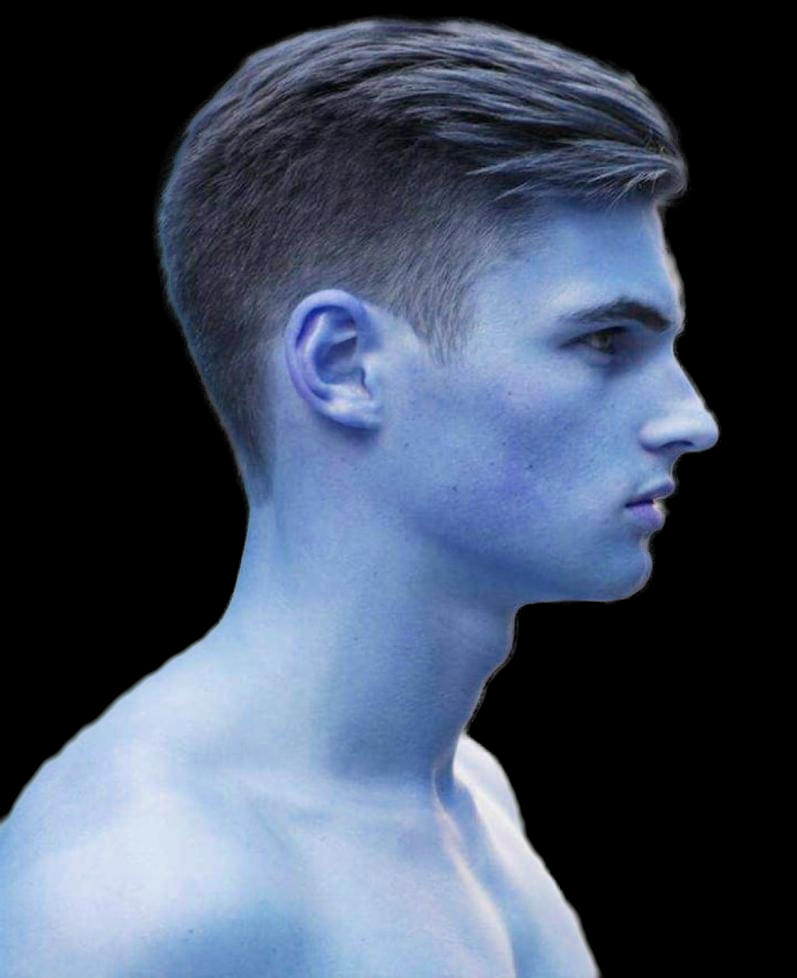

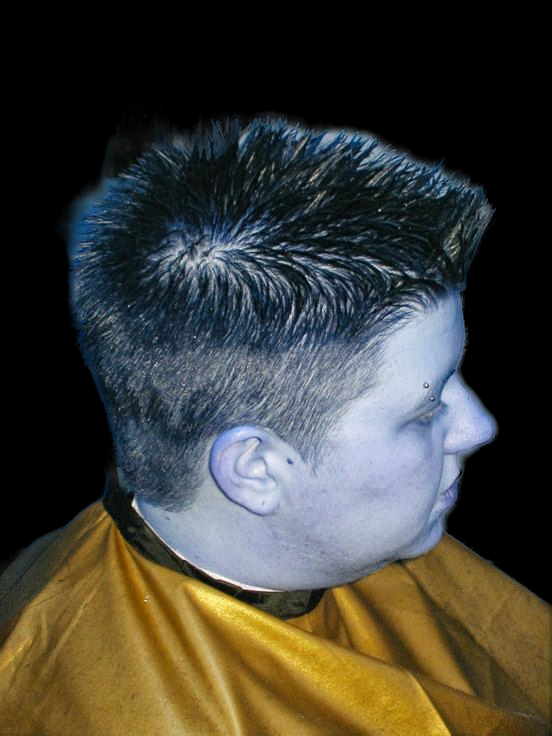

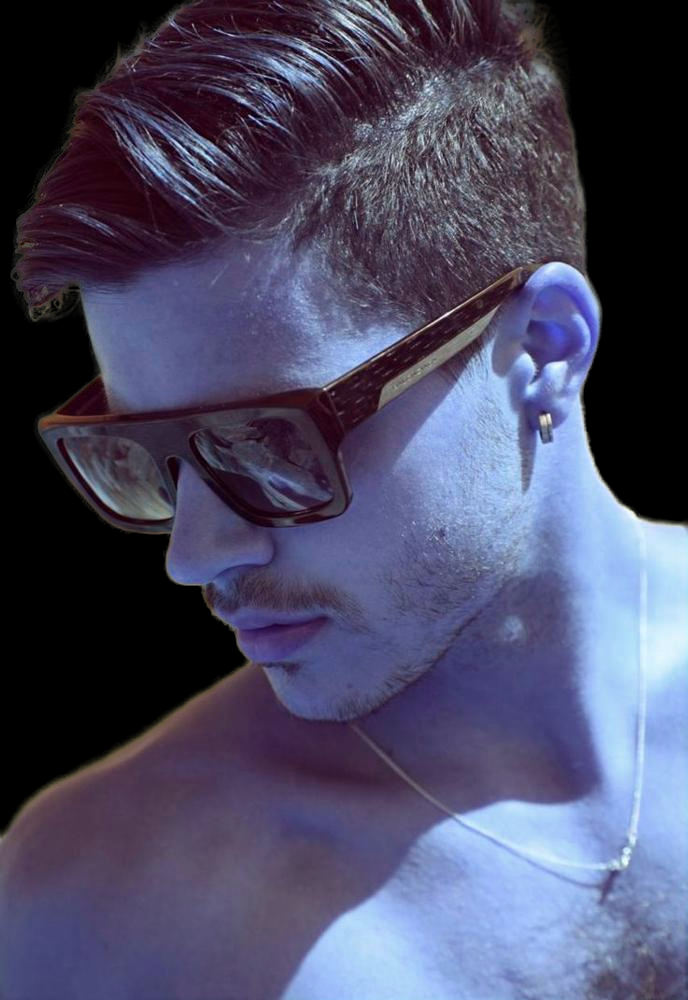

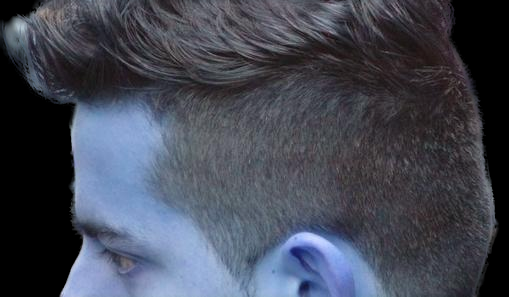

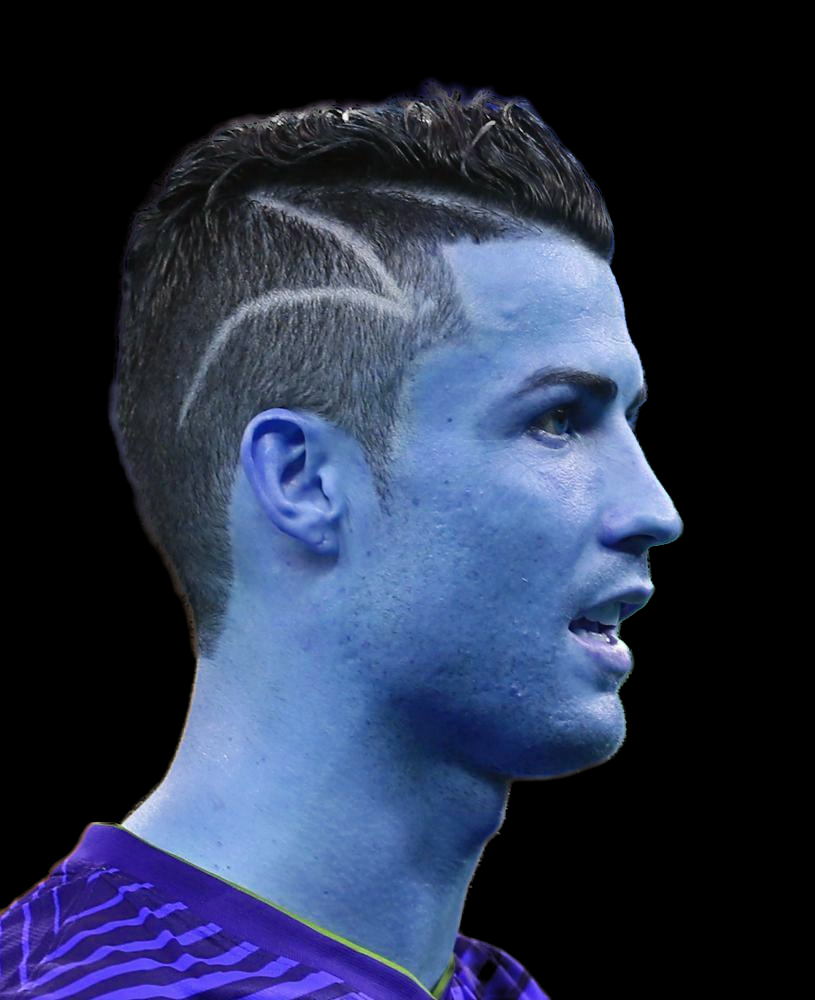

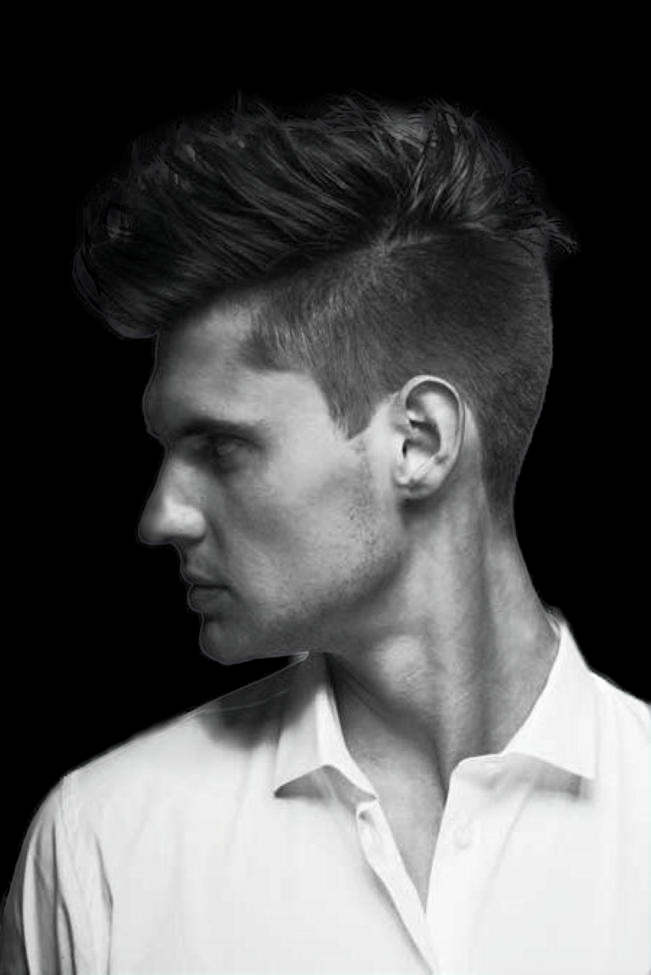

KeyboardInterrupt: 

In [406]:
# path = '/mnt/vitasoft/kobaco_batch/Video.frame/20211112223104/763848F02_1-18-TH-07-531/*'
path = '/mnt/vitasoft/kobaco/sketchy/RobustVideoMatting/src/*.jpg'

from glob import glob
with torch.no_grad():
    for item in glob(path):
    #     img = cv2.imread('../U-2-Net/test_img.jpg')
        img = cv2.imread(item)
        src = cv2_frame_to_cuda(img).cuda()
        model.cuda()
        model.eval()
        rec = [None] * 4
        fgr, pha, *rec = model(src.cuda(), *rec, 0.4) 
        com = fgr * pha + 0 * (1 - pha)
        com = com.mul(255).byte().cpu().permute(0, 2, 3, 1).numpy()[0]
        com = cv2.cvtColor(com, cv2.COLOR_RGB2BGR)
        im = Image.fromarray(com)
        display(im)

In [462]:
import random
image = cv2.imread(bgpath[200])
bg_h, bg_w = image.shape[:2]
mask = np.zeros((bg_h, bg_w))

## random choice num of attach images
num_of_at = random.randrange(1, 5)
print(num_of_at)
model.cuda()
model.eval()

while(1):
    if num_of_at == 0:
        break
    
    at_idx = random.randrange(0,len(self_impath))
    
    at_img = cv2.imread(self_impath[at_idx])
    at_mask = cv2.imread(self_maskpath[at_idx])
    at_mask = cv2.cvtColor(at_mask, cv2.COLOR_BGR2GRAY)

    ## random resize
    h, w = at_img.shape[:2]
    at_resize_factor = random.uniform(0.1, 1.0)
    dsize = (int(w*at_resize_factor),int(h*at_resize_factor))
    at_img = cv2.resize(at_img,dsize=dsize)
    at_mask = cv2.resize(at_mask,dsize=dsize)

    ## remove background of attach image
    with torch.no_grad():
        src = cv2_frame_to_cuda(at_img).cuda()
        rec = [None] * 4
        fgr, pha, *rec = model(src.cuda(), *rec, 0.4) 
        com = fgr * pha + 0 * (1 - pha)
        com = com.mul(255).byte().cpu().permute(0, 2, 3, 1).numpy()[0]
        at_img = cv2.cvtColor(com, cv2.COLOR_RGB2BGR)
    
    ## random locate selection
    max_locate_h = bg_h-dsize[1]
    max_locate_w = bg_w-dsize[0]

    if max_locate_h <= 0 or max_locate_w <= 0:
        continue

    locate_h = random.randrange(0, max_locate_h)
    locate_w = random.randrange(0, max_locate_w)

    ## attach img to background
    mask_ = np.zeros(at_img.shape)
    mask_[at_img==0] = 255
    mask_ = mask_.astype(np.uint8)
    mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY)

    mask_inv = 255 - mask_
    fg = cv2.bitwise_and(at_img, at_img, mask=mask_inv)
    crop_image = image[locate_h:locate_h+dsize[1], locate_w:locate_w+dsize[0],:]
    bg = cv2.bitwise_and(crop_image, crop_image, mask=mask_)
    
    
    image[locate_h:locate_h+dsize[1], locate_w:locate_w+dsize[0],:] = fg+bg
    
    crop_mask = mask[locate_h:locate_h+dsize[1], locate_w:locate_w+dsize[0]]
    crop_mask[at_mask==255] = 255
    
    mask[locate_h:locate_h+dsize[1], locate_w:locate_w+dsize[0]] = crop_mask
    num_of_at -= 1

mask = np.expand_dims(mask, axis=2)

3


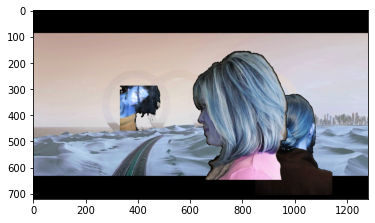

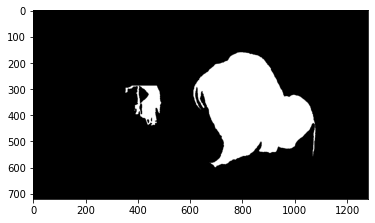

In [463]:
# plt.imshow(at_img)
# plt.show()
# plt.imshow(at_mask, cmap='gray')
# plt.show()
plt.imshow(image)
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()

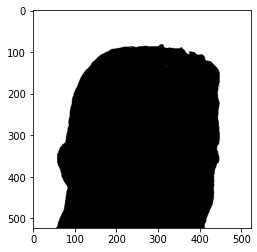

(523, 523)
(523, 523, 3)
(350, 349)


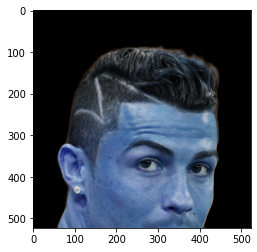

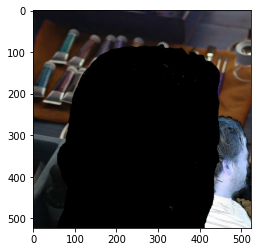

In [450]:
mask = np.zeros(at_img.shape)
mask[at_img==0] = 255
mask = mask.astype(np.uint8)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
plt.imshow(mask,cmap='gray')
plt.show()
print(mask.shape)
print(at_img.shape)

# at_img_gray = cv2.cvtColor(at_img, cv2.COLOR_BGR2GRAY)
print(at_img_gray.shape)
mask_inv = 255 - mask
fg = cv2.bitwise_and(at_img, at_img, mask=mask_inv)
crop_image = image[locate_h:locate_h+dsize[1], locate_w:locate_w+dsize[0],:]
bg = cv2.bitwise_and(crop_image, crop_image, mask=mask)
image[locate_h:locate_h+dsize[1], locate_w:locate_w+dsize[0],:] = fg+bg

plt.imshow(fg)
plt.show()
plt.imshow(bg)
plt.show()

In [199]:
transform = A.Compose([
        A.RandomScale(scale_limit=(-0.6, -0.6), p=1), #LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(256, 256, border_mode=0), #pads with image in the center, not the top left like the paper
        A.RandomCrop(256, 256),
        CopyPaste(blend=True, sigma=1, pct_objects_paste=0.8, p=1., always_apply=True) #pct_objects_paste is a guess
    ], bbox_params=A.BboxParams(format="pascal_voc", min_visibility=0.05)
)
# blend=True,
# sigma=3,
# pct_objects_paste=0.1,
# max_paste_objects=None,
# p=0.5,
# always_apply=False

In [140]:
transform2 = A.Compose([
        # A.RandomScale(scale_limit=(-0.9, 1), p=1), #LargeScaleJitter from scale of 0.1 to 2
        # A.PadIfNeeded(256, 256, border_mode=0), #pads with image in the center, not the top left like the paper
        # A.RandomCrop(256, 256),
    ], bbox_params=A.BboxParams(format="coco", min_visibility=0.05)
)

In [48]:
data = CocoDetectionCP(
    './coco/train2014/', 
    './coco/annotations/instances_train2014.json', 
    transform
)

In [64]:
data2 = FigaroDataset(transform2)

In [281]:
import glob
import numpy as np
from PIL import Image
impath = glob.glob('/home/ubuntu/workspace/U-2-Net_portrait_sketch/Figaro1k/train/src/*.jpg')
maskpath = glob.glob('/home/ubuntu/workspace/U-2-Net_portrait_sketch/Figaro1k/train/mask/*.pbm')

path = impath[1]
mask_path = maskpath[1]

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = Image.open(mask_path).convert("L")
mask = np.array(mask)

obj_ids = np.unique(mask)
obj_ids = obj_ids[1:]
masks = mask == obj_ids[:, None, None]
num_objs = len(obj_ids)

class_id = 1
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin,ymin,xmax,ymax,class_id])

# print(masks.shape)
masks = [masks.squeeze(0)]

output = {
            'image': image,
            'masks': masks,
            'bboxes': boxes,
        }

In [308]:
data2 = FigaroDataset(transform)

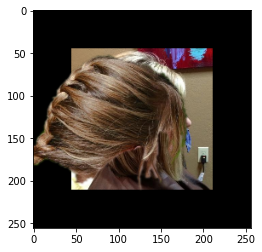

3


In [317]:
img_data = data2[16]
image = img_data['image']
masks = img_data['masks']
bboxes = img_data['bboxes']
plt.imshow(image)
plt.show()
print(len(masks))

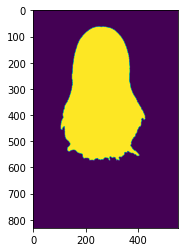

In [136]:
plt.imshow(masks[0])
plt.show()

In [185]:
data3 = CocoDetectionCP(
    './coco/train2014/', 
    './coco/annotations/instances_train2014.json', 
    transform
)

loading annotations into memory...
Done (t=15.83s)
creating index...
index created!


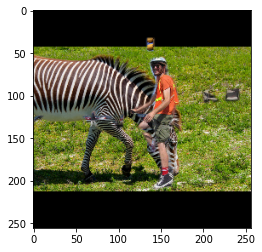

In [320]:
img_data = data3[3]
image = img_data['image']
masks = img_data['masks']
bboxes = img_data['bboxes']
plt.imshow(image)
plt.show()

In [259]:
masks[0].shape

(256, 256)